# Airline Review Analysis - In Progress


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

## Data Gathering and Cleaning

Initially, I thought of scrapping the [skytrax](vhttps://www.airlinequality.com/) website, which seemed pretty easy. Before doing that however, a quick search showed me that someone has already done that and the [data uploaded on Kaggle](https://www.kaggle.com/efehandanisman/skytrax-airline-reviews) is fairly recent.  
  
Actually, the fact that it does not include reviews of the last months may be a good thing. As I was browsing skytrax I noticed many recent negative reviews of cancellations, new no-refund policies and lockdown measures, that were caused by Covid-19. Hopefully, this does not reflect the reality of air traveling and we avoid using it in our analysis. 

In [2]:
# We drop the aircraft column since it has many NaN values and is not important for our analysis
df = pd.read_excel('datasets/capstone_airline_reviews3.xlsx').drop(['aircraft'], axis=1)

# Many fields will remain empty, but depending on our use case we will accordingly deal with them
df = df.dropna(how='all')

In [3]:
display(df)

,airline,overall,author,review_date,customer_review,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
1,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,âœ… Trip Verified | London to Izmir via Istanb...,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,yes
3,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,no
5,Turkish Airlines,3.0,M Galerko,7th May 2019,âœ… Trip Verified | Rome to Prishtina via Ista...,Business,Economy Class,Rome to Prishtina via Istanbul,2019-05-01 00:00:00,1.0,4.0,1.0,3.0,1.0,2.0,no
7,Turkish Airlines,10.0,Zeshan Shah,6th May 2019,âœ… Trip Verified | Flew on Turkish Airlines I...,Solo Leisure,Economy Class,Washington Dulles to Karachi,April 2019,4.0,5.0,5.0,5.0,5.0,5.0,yes
9,Turkish Airlines,1.0,Pooja Jain,6th May 2019,âœ… Trip Verified | Mumbai to Dublin via Istan...,Solo Leisure,Economy Class,Mumbai to Dublin via Istanbul,2019-05-01 00:00:00,1.0,1.0,1.0,1.0,1.0,1.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131886,Ukraine International,NaN,Yevheniy Kahanovych,21st January 2007,Two domestic flights between Kiev and Lviv las...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
131888,Ukraine International,NaN,Helen Lee,15th December 2006,I had a good flight from London to Kiev with U...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
131890,Ukraine International,NaN,Andriy Yesypenko,19th May 2006,Kiev - London (Gatwick) in business class (in ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no
131892,Ukraine International,NaN,Volodya Bilotkach,29th April 2006,Several flights - KBP to AMS (3 times one way)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no


This is a first read for our dataset and we have a lot of cleaning up to do. Depending on what data we need for our analysis we must deal with the remaining `NaN` values.  
Also on the `customer_review` field we can see some unicode characters that must be dealt with.

## Most Important Rating

Each review has a number of ratings:
* Food & Beverages
* Inflight Entertainment
* Seat Comfort
* Value For Money
* Cabin Staff Service
* Ground Service

THe ratings have a value from 1 (being the worst) to 5 (being the best). I would like to find which one of the ratings is the most correlated with **if he would recommend the flight**.  
  
Why I consider the *recommend* value as the best reflection of passenger satisfaction?
If a passenger recommends an airline then this means two things. Firstly, that he would promote to a friend/family the airline. Secondly, in future air traveling is probable that hew would again choose the same airline if possible. From a business perspective I believe this makes the *recommend* metric important.  

### Missing Values

As expected many of the reviews have missing values. The quick approach is to drop all the rows with missing values on the columns we need. We will do that and check how many rows we lose.

In [21]:
# Select the columns we need from the df
rate_importance_df = df.iloc[:,-7:].copy()

# We drop the rows that have a NaN value on the recommended column
rate_importance_df = rate_importance_df[rate_importance_df['recommended'].notna()]

print(f"Rows including NaNs: {len(rate_importance_df)}")

rate_importance_df = rate_importance_df.dropna()

print(f"Rows without NaNs: {len(rate_importance_df)}")

Rows including NaNs: 64440
Rows without NaNs: 24596


We lose about 40.000 rows but we still have ~25.000 rows. At least initially I feel that the remaining rows are enough and no other strategy is followed.

### Correlation

We will now calculate the correlation of each rating with if the *recommendation* value.  
  
Our results will not have a simple interpretation, meaning we must take into account that [**correlation does not imply causation**](https://www.tylervigen.com/spurious-correlations).  
  
**Hypothetical scenario:**  
Let's say we found a great correlation (r >0.9) between recommend and inflight entertainment. One might suggest we should make our flights more entertaining, so we install TVs, music, etc. but after some months we do not have the expected increase on ratings.  
With further analysis we discover that the duration of the flight is highly correlated with the inflight entertainment and consequently with the recommend value.  
This means that long haul flights make the passengers more easily bored and tired and we cannot actually do much about this specific issue since [airplanes will not get much faster](https://aviation.stackexchange.com/a/31386).

In [22]:
# Change the yes/no values on recommend column to 1/0
rate_importance_df.recommended = rate_importance_df.recommended.map(dict(yes=1, no=0))

In our case we have a continuous value for the ratings and a binary value (yes/no) for the recommend value. So, we will use the [point-biserial correlation coefficient](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient) which is a [special case of Pearson correlation](https://stats.stackexchange.com/a/105553).  
  
Firstly, I will plot some boxplots which will be a pretty good indication if there is any correlation, before quantifying it.

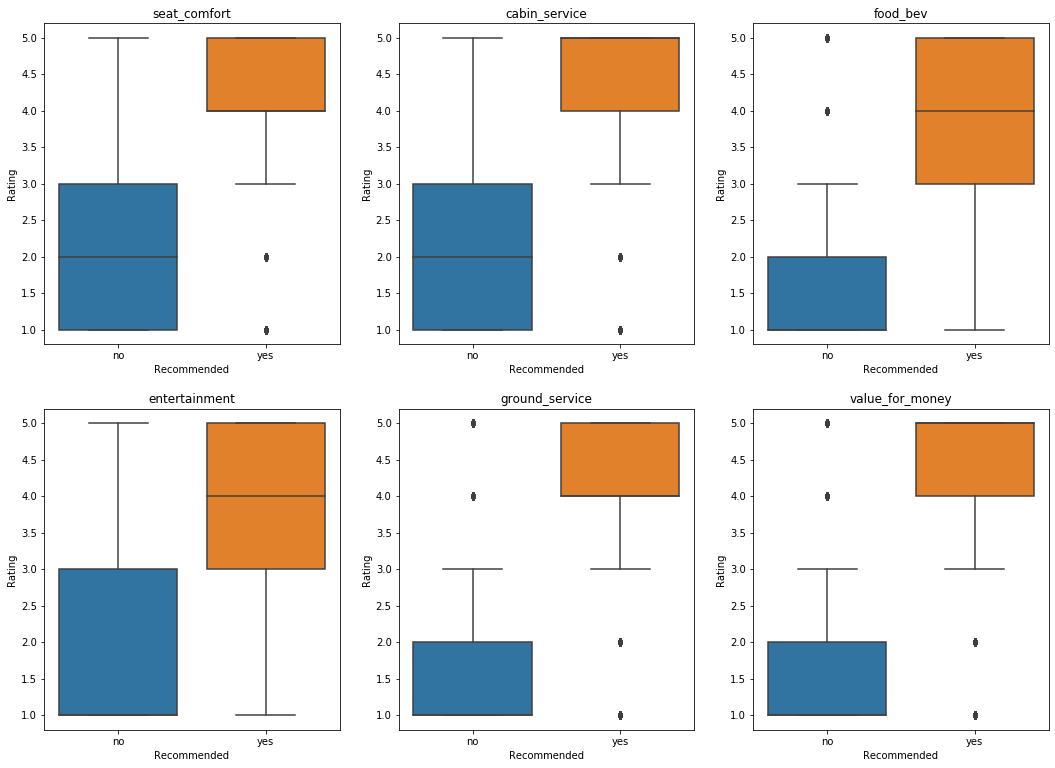

In [83]:
fig = plt.figure(figsize=(18, 13))
plot_index = 1

# Iterate on all the ratings
for which_rating in rate_importance_df.columns[:-1]:
    ax = fig.add_subplot(2, 3, plot_index)
    yes_ratings = np.array(rate_importance_df.loc[rate_importance_df['recommended'] == 1][which_rating])
    no_ratings = np.array(rate_importance_df.loc[rate_importance_df['recommended'] == 0][which_rating])

    ax = sns.boxplot(data=[no_ratings, yes_ratings])
    plt.xticks(range(0, 2), ["no", "yes"])
    plt.title(which_rating)
    plt.ylabel("Rating")
    plt.xlabel("Recommended")
    plot_index += 1

plt.show()


On the above plots we can see that all the ratings are correlated. A low rating on any of these, means a "no" on recommendation and vice versa.  
An observation is, that when we are rating **we are biased from our overall experience**. That means if for example the ground_service is bad this might affect our whole view of the flight negatively and be biased when rating the cabin_service etc.  
This can be shown by calculating the correlations between ratings. This shows **correlation "chains"** which do not allow us to be able to distinguish which one is the most important rating.

In [82]:
# Let's calculate the correlation
for which_rating in rate_importance_df.columns[:-1]:
    r, p = stats.pointbiserialr(rate_importance_df.recommended, rate_importance_df[which_rating])
    print(f"{which_rating},\tr = {np.round(r, decimals=3)} with p-value={p}")

seat_comfort,	r = 0.727 with p-value=0.0
cabin_service,	r = 0.745 with p-value=0.0
food_bev,	r = 0.738 with p-value=0.0
entertainment,	r = 0.652 with p-value=0.0
ground_service,	r = 0.751 with p-value=0.0
value_for_money,	r = 0.838 with p-value=0.0


As we can see most of them have the same levels of r-coefficients with entertainment being a bit lower and value for money a bit higher (which is expected since value for money can be considered as a summarizing rating of all the other ratings).  
  
**So by simply looking at the ratings I believe we cannot have a decisive answer on what the airlines should improve.**

## Review Text Processing

Since the above analysis does not have a clear results we will now try to have insights from the text of the reviews. This sounds more helpful, because although the ratings are biased from the overall experience the text should be focused on more specific events.